# score
A film's score adds emotional impact to the action onscreen. *King Kong* (1933) was the first film to incorporate a full orchestra score, adding weight to Kong's rampage. The famous shower scene in *Pyscho* (1960) wouldn't be nearly as frightening without the violin screeches. And the two notes of the shark's theme in *Jaws* (1975) was a big source of suspense for the POV underwater stalking scenes.

In [1]:
import librosa
from librosa.display import waveplot, specshow
import matplotlib.pyplot as plt
import numpy as np
from pychord import Chord, note_to_chord
from pychord.utils import val_to_note
from pychord.constants import scales
from pychord.analyzer import notes_to_positions, get_all_rotated_notes

First, we'll take a look at what we can understand from "Alone in Kyoto", a song in *Lost in Translation* (2003). *Lost in Translation*, a film about loneliness and isolation, benefits from a score with heavy use of shoegaze: slow, ethereal, and introspective.

"Alone in Kyoto", by the electronic group Air, is a slow, minimalistic song that accompanies Scarlett Johansson's character as she wanders through Japanese temples alone, taking in the foreign sights and customs.

In [2]:
audio_file = ('../extracted_audio/score/kyoto.wav')

In [3]:
y, sr = librosa.load(audio_file)

## Visualizations
There are no diagetic (in-story) sounds in this part of the film; only the music is being analyzed. We can generate the waveplot and chromagram to visualize the song.

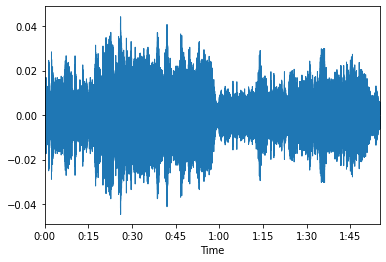

In [4]:
waveplot(y, sr)

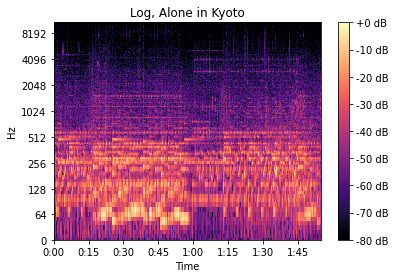

In [5]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Log, Alone in Kyoto')
fig.colorbar(img, ax=ax, format="%+2.f dB")

## Tempo
`librosa` can estimate the tempo — it clocks in at a slow 89 beats per minute (BPM).

In [6]:
librosa.beat.tempo(y, sr)

array([89.10290948])

## Chromagram and chroma features
The chroma features can be extracted to estimate with notes/pitch classes are present at each time window. The chromagram provides a visualization — it looks like the D note is the most prevalent.

[Text(0.5, 1.0, 'Chromagram, Alone in Kyoto')]

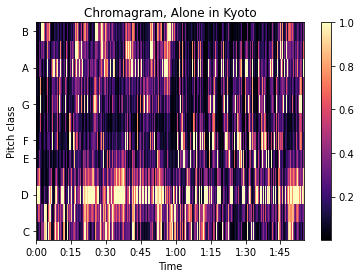

In [7]:
chroma = librosa.feature.chroma_stft(y, sr)
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram, Alone in Kyoto')

`chroma_stft()` returns an array of intensities for each of the 12 notes. Again, D is the most prevalent.

In [8]:
chroma.shape

(12, 4953)

In [9]:
chroma[0].mean() # mean intensity for C notes

0.40061817

In [10]:
chroma[2].mean() # mean intensity for D notes

0.6281621

We can `reshape()` this array to see each of the 12 pitches' intensities at a given time window.

In [11]:
chroma_window = chroma.reshape(4953, 12)

In [12]:
chroma_window[0]

array([0.07661644, 0.02667749, 0.03230091, 0.08452199, 0.08287171,
       0.05250483, 0.2567601 , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

### Major and Minor Scales
We'll want to evaluate how the score directs our emotional response. At its most simplified level, the score music is happy or sad. As a general, broad rule of thumb, music composed in major scales are happy, and and music composed in minor scales are sad.

Scales are composed of seven of the 12 pitch classes. Using chroma_stft() gives us the mean intensity of all 12, making a best effort to group audio data into the 12 pitch classes. By looking at the list of top seven, we may be able to map these to major and minor scales.

In [13]:
note_means = []
for note in chroma:
    note_means.append(note.mean())

In [14]:
note_means = np.array(note_means)

In [15]:
top_seven_semitones = note_means.argsort()[-7:][::-1]
top_seven_semitones

array([ 2,  1,  0,  9,  3,  5, 10])

In [16]:
top_seven_semitones.sort()
top_seven_semitones

array([ 0,  1,  2,  3,  5,  9, 10])

In [17]:
top_seven_notes = []
for semitone in top_seven_semitones:
    top_seven_notes.append(val_to_note(semitone))

In [18]:
top_seven_notes

['C', 'Db', 'D', 'Eb', 'F', 'A', 'Bb']

While we know the top seven semitones, we don't know which is the roote note. We'll have to "rotate" this combination of seven notes, and consider each note as the root.

In [19]:
rotated = get_all_rotated_notes(list(top_seven_semitones))
rotated

[[0, 1, 2, 3, 5, 9, 10],
 [1, 2, 3, 5, 9, 10, 0],
 [2, 3, 5, 9, 10, 0, 1],
 [3, 5, 9, 10, 0, 1, 2],
 [5, 9, 10, 0, 1, 2, 3],
 [9, 10, 0, 1, 2, 3, 5],
 [10, 0, 1, 2, 3, 5, 9]]

Next, we have to normalize each root as the 0th note.

In [20]:
normalized_note_lists = []
for note_list in rotated:
    normalized = []
    for note in note_list:
        normalized.append((note - note_list[0]) % 12)
    normalized_note_lists.append(normalized)

In [21]:
normalized_note_lists

[[0, 1, 2, 3, 5, 9, 10],
 [0, 1, 2, 4, 8, 9, 11],
 [0, 1, 3, 7, 8, 10, 11],
 [0, 2, 6, 7, 9, 10, 11],
 [0, 4, 5, 7, 8, 9, 10],
 [0, 1, 3, 4, 5, 6, 8],
 [0, 2, 3, 4, 5, 7, 11]]

With our seven normalized note lists, we can check if each follows the pattern for a major or minor scale. We look at the interval pattern. In a scale, the next note is either a half or a whole jump. We can identify a major or minor scale as long as it fits this pattern — regardless of the root note.

- Major: whole, whole, half, whole, whole, whole, half
- Minor: whole, half, whole, whole, half, whole, whole

In [22]:
major_flag = 0
minor_flag = 0

major_intervals = [0, 2, 4, 5, 7, 9, 11]
minor_intervals = [0, 2, 3, 5, 7, 8, 10]

for note_list in normalized_note_lists:
    if note_list == major_intervals:
        major_flag = 1
    elif note_list == minor_intervals:
        minor_flag == 1

In [23]:
print(major_flag)
print(minor_flag)

0
0


We were unable to classify this as a major or a minor scale. However, in the future we can check other scales/modes, such as the dorian mode, which is commonly used in film scores.

### Major and Minor Chords
We may also want to identify major and minor chords. Again, major chords are happy, and minor chords sad. Chords are made of three or four individual notes to create (what sounds like) a single tone.

Here, we can find a minor chord, the diminished triad for the root note C (Cdim) in a French-inspired scene transition in *The Hustle* (2019).

In [24]:
audio_file = ('../extracted_audio/score/french_transition.wav')
y, sr = librosa.load(audio_file)
chroma = librosa.feature.chroma_stft(y, sr)
chroma_window = chroma.reshape(862, 12)

For each time window, we can look for each pitch above a certain intensity. In the below example, we found three semitones in this window, index numbers 0, 3, 6, corresponding to the notes C, E-flat, and G-flat.

In [25]:
frame_semitones = np.argwhere(chroma_window[205] > 0.6)
frame_semitones

array([[0],
       [3],
       [6]])

We can make use of the `pychord` library to look up notes. By passing in the semitone numbers, we can convert these to notes using `val_to_note(), and then use the `note_to_chord` function to confirm that these notes correspond with the C diminished triad.

In [26]:
frame_notes = []
for note in frame_semitones[:,0]:
    frame_notes.append(val_to_note(note))

frame_notes

['C', 'Eb', 'Gb']

In [27]:
note_to_chord(frame_notes)

[<Chord: Cdim>]

### Scale Identification
In an earlier section, we simply attempted to calculate whether a scale was minor or major. But we may want to identify the specific root note, (e.g. identifying A minor instead of just a generic minor scale). Some music theorists believe that each root note evokes different feelings, so we may want to be more specific.

The `pychord` library doesn't have built-in functions to identify scales, but it does have reference dictionaries for chord calculations. We can use these dictionaries to calculate the notes for any given pitch and major/minor combination. Below we can look up the notes for the A minor scale.

In [28]:
scale_notes = []
minor_major = 'min'
root_pitch = 'A'

for semitone in scales.RELATIVE_KEY_DICT[minor_major]:
    scale_notes.append(scales.SCALE_VAL_DICT[root_pitch][(semitone + scales.NOTE_VAL_DICT[root_pitch])%12])

scale_notes

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'A']

## Diegetic vs. Non-Diegetic Music
We’ll also want to differentiate between diegetic and non-diegetic music. Non-diegetic music has been overlaid on top of the film’s soundtrack, with the implication that it isn’t part of the in-movie story. Diegetic music is in-universe, and may be a song on a car radio, or a character singing karaoke. 

### Chromagram frequencies
We may be able to tell the difference by looking at the song’s frequencies. Below are two spectrograms for the Alanis Morrissette hit “You Oughta Know”. One is the audio from *Booksmart* (2019), where the song is performed at a karaoke party; the other is the album version.

In [29]:
audio_file = ('../extracted_audio/score/booksmart_karaoke.wav')
y, sr = librosa.load(audio_file, duration=20, offset=10)

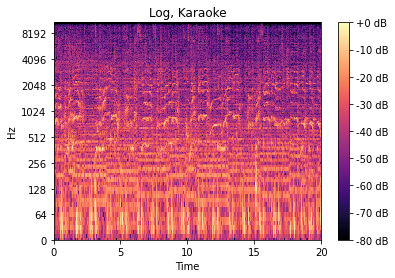

In [30]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Log, Karaoke')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [31]:
audio_file = ('../extracted_audio/score/booksmart_karaoke_album.mp3')
y, sr = librosa.load(audio_file, duration=20, offset=10)

/home/collect/anaconda3/envs/moviegoer/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


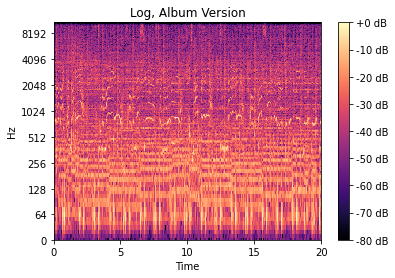

In [32]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Log, Album Version')
fig.colorbar(img, ax=ax, format="%+2.f dB")

For now, we can't exactly tell the difference between the two versions by sight, from the chromagram.